In [1]:
import numpy as np
from pathlib import Path
import cv2
from matplotlib import pyplot as plt
import pandas as pd

import re


def resolve_filenames_to_string(path: Path):
    """Converts paths to strings"""
    return list(map(lambda x: str(x.resolve()), path))


def load_image(image_path):
    """Loads cv2 image and changes channel structure to RGB"""
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def get_batch_image_paths(path: Path):
    """Get image paths based on batch and returns dict with information"""
    front_img_glob = list(path.glob("*Front.png"))
    image_indexes = list(map(lambda x: int(x.name.split("_")[1]), front_img_glob))

    front_images_paths = resolve_filenames_to_string(front_img_glob)
    side_images_paths = resolve_filenames_to_string(path.glob("*Side.png"))
    angle_images_paths = resolve_filenames_to_string(path.glob("*Angle.png"))

    dict_res = {
        v: {
            "Front": front_images_paths[ind],
            "Side": side_images_paths[ind],
            "Angle": angle_images_paths[ind],
        }
        for ind, v in enumerate(image_indexes)
    }
    return dict_res


def read_file(path_str):
    """Open and reads file"""
    with open(path_str) as f:
        res = f.read()
    return res


def extract_information_from_data(path_str):
    """Extracts revelant infromation from file using regex and returns tuple of arrays"""
    file_data = read_file(path_str)
    image_ind = re.findall(r"'id':(\d+)", file_data)
    brows_arch = re.findall(r"'Brows Arch': \{(-?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?)\}", file_data)
    brows_centre_depth = re.findall(
        r"'Brows Centre Depth': \{(-?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?)\}", file_data
    )
    lip_upper_peak_height = re.findall(
        r"'Lip Upper Peak Height': \{(-?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?)\}", file_data
    )
    dome_rotation = re.findall(
        r"'dome rotation':(\d+(?:\.\d+)?),(\d+(?:\.\d+)?),(\d+(?:\.\d+)?),", file_data
    )

    result = (
        np.array(image_ind, dtype="float"),
        np.array(brows_arch, dtype="float"),
        np.array(brows_centre_depth, dtype="float"),
        np.array(lip_upper_peak_height, dtype="float"),
        np.array(dome_rotation),
    )
    return result


def process_vertices(vertices):
    """Processes vertices by splitting 2nd value and converting them to array"""
    coordinates = vertices[1].split(",")
    return np.array(coordinates, dtype="float")


def extract_vertices_and_image_information(path_str):
    """Extracts vertices and image information from file using regex and simple processing. 
        Returns dict with all information and vertices name array
    """
    def update_camera_name(camera_type):
        if camera_type == "45":
            return "Angle"
        return camera_type

    with open(path_str) as f:
        vertex_info = f.read()

    regex_image_camera_pattern = r'"batch":\s*\[.*?"camera=Camera_(\w+)".*?"image=(\d+)"'
    camera_and_image_info = re.findall(regex_image_camera_pattern, vertex_info)
    parsed_vertices = re.findall(r'"([^"]+)":\[([^]]+)\]', vertex_info)

    data_points_per_image = len(parsed_vertices) / len(camera_and_image_info)

    processed_camera_and_image_info = [
        (update_camera_name(info[0]), int(info[1])) for info in camera_and_image_info
    ]
    processed_vertices = [process_vertices(vert) for vert in parsed_vertices]

    if data_points_per_image != round(data_points_per_image):
        raise Exception(
            "Images have different number of vertices. Check input file if it's correct."
        )

    final_result = {}
    temp_result = {}
    current_img = processed_camera_and_image_info[0][1]
    for ind, (camera_type, img_n) in enumerate(processed_camera_and_image_info):
        if current_img != img_n:
            final_result[current_img] = temp_result
            temp_result = {}
            current_img = img_n

        data_point_ind1 = int(ind * data_points_per_image)
        data_point_ind2 = int((ind + 1) * data_points_per_image)

        temp_result[camera_type] = np.array(processed_vertices[data_point_ind1:data_point_ind2])

    final_result[img_n] = temp_result

    vertices_names, _ = zip(*parsed_vertices[data_point_ind1:data_point_ind2])

    return final_result, np.array(list(vertices_names))


def find_highest_magnitude_vectors(vector1, vector2, take_top_percent=5, ignore_indexes=[]):
    """Finds highest magnitude vectors and returns their top percentile indexes"""
    differences = np.array(vector2) - np.array(vector1)

    if len(ignore_indexes):
        differences[ignore_indexes] = 0

    magnitudes = np.linalg.norm(differences, axis=1)

    threshold = np.percentile(magnitudes, 100 - take_top_percent)
    significant_indices = np.where(magnitudes > threshold)[0]

    return significant_indices


def get_highest_magnitude_vectors_for_camera_type(
    image_vertices1, image_vertices2, camera_type, take_top_percent=5, max_width=512, max_height=512
):
    """Finds regions of variance for camera type based on highest magnitude vectors"""
    coords1 = image_vertices1[camera_type]
    coords2 = image_vertices2[camera_type]

    coords1_outliers_ind = find_outliers(coords1, max_width=max_width, max_height=max_height)
    coords2_outliers_ind = find_outliers(coords2, max_width=max_width, max_height=max_height)
    ignore_indexes = list(coords1_outliers_ind.union(coords2_outliers_ind))

    return find_highest_magnitude_vectors(coords1, coords2, take_top_percent, ignore_indexes)


def display_image(image_path, x_coords=None, y_coords=None, alpha=0.5):
    """Displays image"""
    image_arr = load_image(image_path)

    f, ax = plt.subplots(1, 1, figsize=(5, 10))
    ax.imshow(image_arr)
    if x_coords is not None and y_coords is not None:
        ax.plot(x_coords, y_coords, "ro", alpha=alpha)

    plt.show()


def show_regions_of_interest(image_dict, front_mask, angle_mask, side_mask):
    """Displays images with all camera types and their masks"""
    f, ax = plt.subplots(3, 2, figsize=(10, 10))
    image_front = load_image(image_dict["Front"])
    image_side = load_image(image_dict["Side"])
    image_angle = load_image(image_dict["Angle"])

    ax[0, 0].imshow(image_front)
    ax[1, 0].imshow(image_side)
    ax[2, 0].imshow(image_angle)

    # mark mask pixels as red
    red_color = np.array([255, 0, 0], dtype=np.uint8)

    front_indexes = np.where(front_mask > 0)
    side_indexes = np.where(side_mask > 0)
    angle_indexes = np.where(angle_mask > 0)

    image_front[front_indexes] = red_color
    image_side[side_indexes] = red_color
    image_angle[angle_indexes] = red_color

    ax[0, 1].imshow(image_front)
    ax[1, 1].imshow(image_side)
    ax[2, 1].imshow(image_angle)

    plt.show()


def get_image_index_in_df(batch_info_df, camera_type, image_ind, batch_id=0):
    """Finds image index in dataframe based on parameters"""
    return batch_info_df.get_group((batch_id, image_ind, camera_type)).index[0]


def get_coordinates_based_on_name(coordinate_names, annotation_df, image_index_in_df=0):
    """Gets coordinates of image from dataframe based on coordinates names parameter"""
    coordinate_names_annotations_x = [f"{n}_x" for n in coordinate_names]
    coordinate_names_annotations_y = [f"{n}_y" for n in coordinate_names]

    x_arr = annotation_df.loc[image_index_in_df, coordinate_names_annotations_x].values
    y_arr = annotation_df.loc[image_index_in_df, coordinate_names_annotations_y].values
    return x_arr, y_arr


def transform_coordinates(x_cords, y_cords, image_shape=(256, 256)):
    """Coordinates are scaled down by 2 times and mirrored y axis. Outliers are filtered out"""
    new_x = x_cords / 2
    new_y = image_shape[1] - y_cords / 2

    outlier_indexes = list(find_outliers(None, image_shape[0], image_shape[1], new_x, new_y))
    index_mask = np.ones(new_x.shape, dtype=bool)
    index_mask[outlier_indexes] = False
    return new_x[index_mask], new_y[index_mask]


def find_batch_folders_and_indexes(path_str):
    """Finds batch folders and their indexes"""
    main_folder_location = Path(path_str)
    batch_folders = list(main_folder_location.glob("*"))
    batch_folder_indexes = [int(re.findall("(\d+)", b.name)[0]) for b in batch_folders]
    return batch_folders, batch_folder_indexes


def load_parameter_set_data(path_str):
    """Loads all parameters for parameter set and returns dict of results"""
    batch_folders, batch_folder_indexes = find_batch_folders_and_indexes(path_str)

    result_dict = {}
    for batch_folder, batch_ind in zip(batch_folders, batch_folder_indexes):

        batch_image_folder_path = batch_folder.joinpath("Rendering")
        batch_data_path_str = str(batch_folder.joinpath("Data.txt").resolve())
        batch_vertex_path_str = str(batch_folder.joinpath("vertex_3k.txt").resolve())

        batch_image_paths = get_batch_image_paths(batch_image_folder_path)

        batch_data_info = extract_information_from_data(batch_data_path_str)

        batch_vertex_info, vertices_names = extract_vertices_and_image_information(
            batch_vertex_path_str
        )

        result_dict[batch_ind] = {
            "ImagePath": batch_image_paths,
            "Data": batch_data_info,
            "Vertices": batch_vertex_info,
            "VerticesNames": vertices_names,
        }
    return result_dict


def find_outliers(coords, max_width, max_height, x_arr=None, y_arr=None):
    """Finds outliers from coords or if not provided, x_arr, y_arr arrays"""
    if coords is not None:
        x, y = np.array(list(zip(*coords)))
    else:
        x, y = x_arr, y_arr
    outlier_indexes_x = np.where(np.abs(x) > max_width)[0]
    outlier_indexes_y = np.where(np.abs(y) > max_height)[0]
    return set(outlier_indexes_x).union(outlier_indexes_y)


def create_mask(image_shape, points, radius=5):
    """Creates a mask for an image based on a list of data points"""
    mask = np.zeros(image_shape, dtype=np.uint8)
    points_array = np.array(points, dtype=np.int32)
    hull = cv2.convexHull(points_array)

    cv2.fillConvexPoly(mask, hull, 255)

    return mask


def find_variation_in_images(parameter_set_batch_info, img_indexes_list, image_size):
    """Finds variation in images and displays variation regions"""
    batches_results = {}
    for batch_index, batch_data_dict in parameter_set_batch_info.items():
        print(f"Batch id: {batch_index}")
        image1_vertices = batch_data_dict["Vertices"][img_indexes_list[0]]
        image2_vertices = batch_data_dict["Vertices"][img_indexes_list[1]]

        front = get_highest_magnitude_vectors_for_camera_type(
            image1_vertices, image2_vertices, "Front", 5
        )
        angle = get_highest_magnitude_vectors_for_camera_type(
            image1_vertices, image2_vertices, "Angle"
        )

        side = get_highest_magnitude_vectors_for_camera_type(
            image1_vertices, image2_vertices, "Side"
        )
        image1_path = batch_data_dict["ImagePath"][img_indexes_list[0]]

        x, y = np.array(list(zip(*image1_vertices["Front"])))
        display_image(image1_path["Front"], x[front], y[front])

        fr = create_mask(image_size, image1_vertices["Front"][front])
        angl = create_mask(image_size, image1_vertices["Angle"][angle])
        sid = create_mask(image_size, image1_vertices["Side"][side])

        show_regions_of_interest(batch_data_dict["ImagePath"][img_indexes_list[0]], fr, angl, sid)
        # Stores information about batch index and corresponding camera type indexes of points that vary in images
        batches_results[batch_index] = {"Front": front, "Side": side, "Angle": angle}

    return batches_results


def get_masks_for_training_set_camera_type(
    coordinate_names, annotation_df, batch_info_df, image_ind, camera_type, image_size
):
    """Creates masks for training set image based on camera type"""
    image_index_in_df = get_image_index_in_df(batch_info_df, camera_type, image_ind)

    (
        raw_train_coordinates_x,
        raw_train_coordinates_y,
    ) = get_coordinates_based_on_name(coordinate_names, annotation_df, image_index_in_df)

    new_x, new_y = transform_coordinates(
        raw_train_coordinates_x, raw_train_coordinates_y, image_size
    )

    mask = create_mask(image_size, list(zip(new_x, new_y)))

    return mask


def display_variation_on_training_set(
    parameter_set_batch_info,
    annotation_df,
    batch_image_paths,
    analyze_image_ind,
    batch_info_df,
    parameter_variation_results,
    image_size,
):
    """Displays variation of parameter set on training set images"""
    for batch_id, variation_results in parameter_variation_results.items():
        coordinate_names = parameter_set_batch_info[batch_id]["VerticesNames"]
        print(f"Batch id: {batch_id}")

        front_coordinates = coordinate_names[variation_results["Front"]]
        side_coordinates = coordinate_names[variation_results["Side"]]
        angle_coordinates = coordinate_names[variation_results["Angle"]]

        front_mask = get_masks_for_training_set_camera_type(
            front_coordinates, annotation_df, batch_info_df, analyze_image_ind, "Front", image_size
        )
        side_mask = get_masks_for_training_set_camera_type(
            side_coordinates, annotation_df, batch_info_df, analyze_image_ind, "Side", image_size
        )
        angle_mask = get_masks_for_training_set_camera_type(
            angle_coordinates, annotation_df, batch_info_df, analyze_image_ind, "Angle", image_size
        )

        show_regions_of_interest(
            batch_image_paths[analyze_image_ind], front_mask, angle_mask, side_mask
        )



### Reading the data
The structure of data is displayed below:

```
structure: 
{
    batch_id: 
    {
        ImagePath: 
        {
            image_index: 
            {
                Front: path, 
                Side: path, 
                Angle: path
            }
        }, 
        Data: tuple of arrays that represent Data.txt information, 
        Vertices:
        {
            image_index: 
            {
                Front: data_points, 
                Side: data_points, 
                Angle: data_points
            }
        }
        VerticesNames: array of vertices names
    }
}
```


In [2]:
parameter_set_batch_info = load_parameter_set_data("parameter set")

In [3]:
parameter_set_batch_info[1].keys()

dict_keys(['ImagePath', 'Data', 'Vertices', 'VerticesNames'])

### Find regions of variation in each batch of images

Simple approach was used to find variation areas in images:
- 2 consecutive images were selected
- magnitude of coordinates differences was calculated
- outliers were identified and ignored
- top 5 % with highest magnitude values were selected as variation coordinates
- convex hull was created based on the coordinates
- coordinate names were stored for later use

Batch id: 1


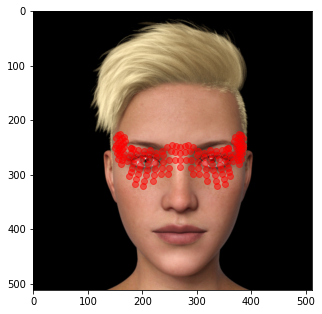

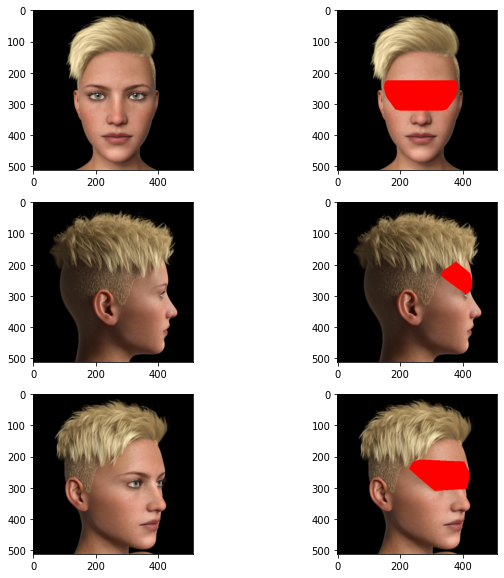

Batch id: 2


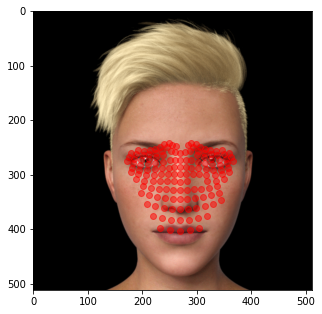

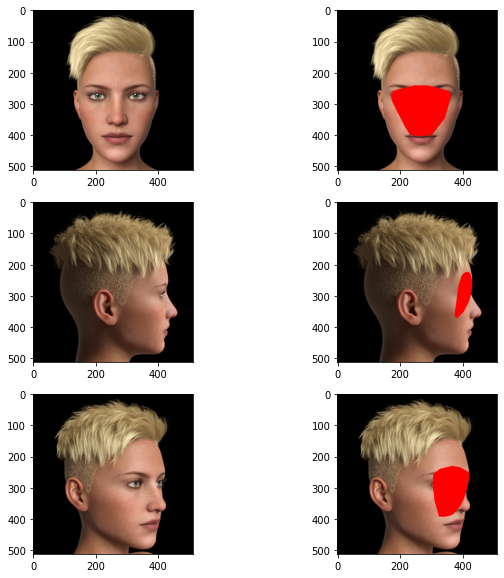

In [4]:
image_size = load_image(parameter_set_batch_info[1]["ImagePath"][0]["Front"]).shape[:-1]
img_indexes_list = [25, 26]
parameter_variation_results = find_variation_in_images(parameter_set_batch_info, img_indexes_list, image_size)


### Correctly "draw" the change regions on the images from the "train set" folder
- Coordinate names from previous cell are used to identify which coordinates belong to region of variation
- Coordinates are adjusted based on current image - scaled down by 2 times, and y axis mirrored
- Outliers are removed
- Convex hull is created based on the coordinates and displayed on examples

Batch id: 1


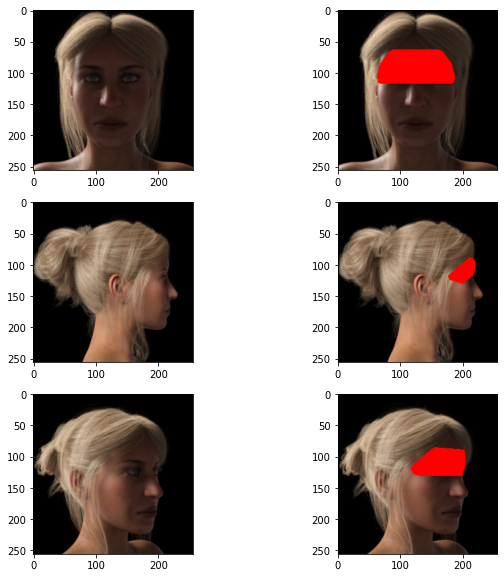

Batch id: 2


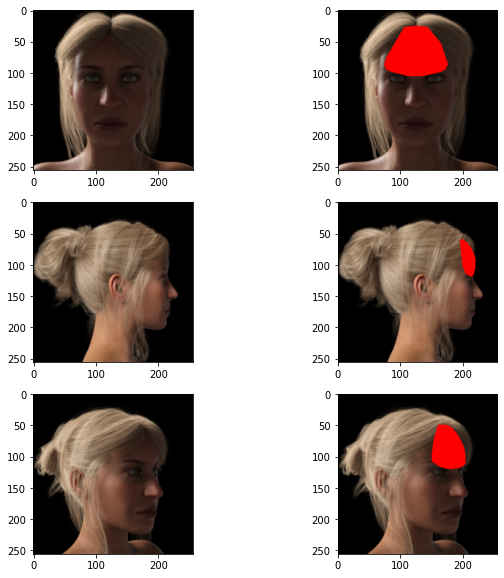

In [5]:
annotation_df = pd.read_csv("Annotations/train_set-1-full.csv", index_col=0)
batch_image_paths = get_batch_image_paths(Path("train set/batch01/Rendering"))
batch_info_df = annotation_df[["batch_id", "id", "camera_type"]].groupby(
    ["batch_id", "id", "camera_type"]
)

analyze_image_ind = 10

image_size1 = load_image(batch_image_paths[0]["Front"]).shape[:-1]

display_variation_on_training_set(
    parameter_set_batch_info,
    annotation_df,
    batch_image_paths,
    analyze_image_ind,
    batch_info_df,
    parameter_variation_results,
    image_size1,
)